Group 1 - Model 4 & Multi Model Comparrison.

Chosen dataset: CIFAR-10

**Model by**  Benjamin Hunt


In [1]:
import numpy as np  # Import libraries like CIFAR-10, Numpys and pandas etc.
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential

from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data() # (Training set: 50,000) - (Test set: 10,000) This will remain untouched until the final evaluation.

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step


Visualize the data

<Figure size 393.701x393.701 with 0 Axes>

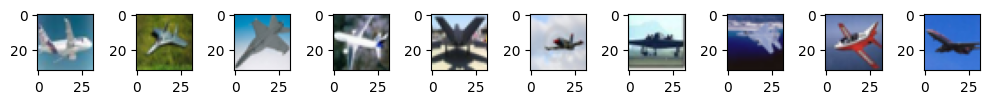

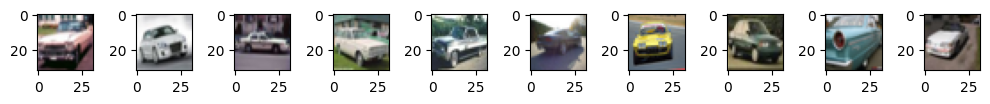

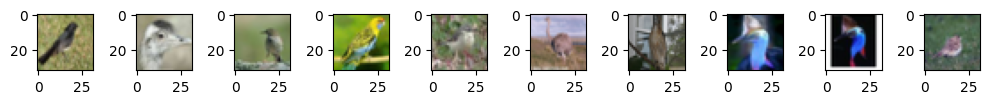

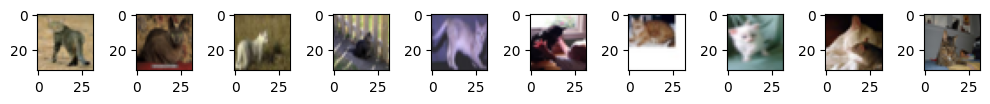

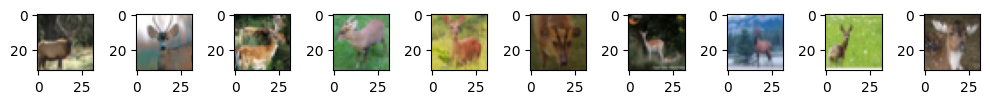

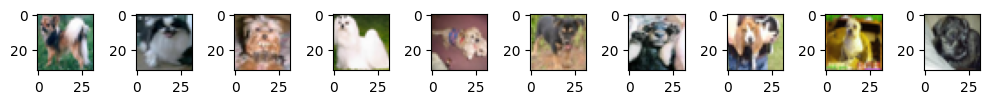

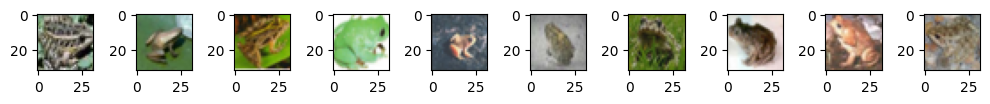

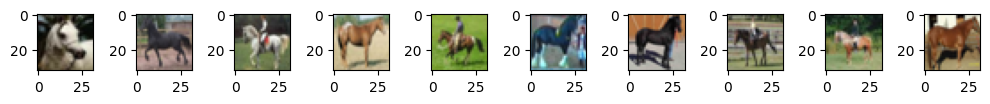

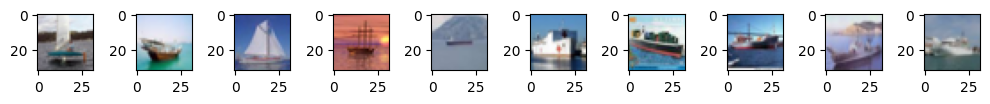

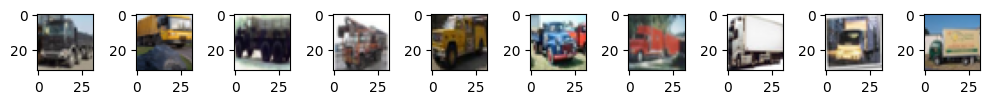

In [3]:

# print(x_train.shape) (check model shape)

num_classes = 10

fig = plt.figure(figsize=(10*1/2.54, 10*1/2.54)) # class to img plot ratio.

for idx_class in range(num_classes): # This section loops through class labels and shows sample images so we can check the dataset format and variety.

  all_idx = np.where(y_train.flatten() == idx_class)[0]

  # Random selection of 10 image of each category
  rand_idx = np.random.choice(all_idx, size=10, replace=False)
  selected = x_train[rand_idx]

  plt.figure(figsize=(10, 10))

  for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(selected[i])
    plt.tight_layout()

  plt.show()

Data normalization

In [4]:
x_train = x_train.astype("float32") / 255 # Neural networks train more stable when they are converted to [ 0 - 1 ], Here it is done with .astype function to normalize the code from [ 0 - 255 ].
x_test = x_test.astype("float32") / 255

print(x_train.shape)
print(x_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


Prepare the labels

In [5]:
# Re-load CIFAR-10 dataset to ensure y_train and y_test are in their original integer label format
# This prevents issues if the cell is run multiple times
from tensorflow.keras.datasets import cifar10

(_, y_train_raw), (_, y_test_raw) = cifar10.load_data()

y_train = to_categorical(y_train_raw, num_classes=10) # Prepare the labels as they class from 0 - 9, this is ideal for catagorical crossentropy.
y_test = to_categorical(y_test_raw, num_classes=10)

print(y_train.shape)      # Here you casn see our train size and test size.
print(y_test.shape)

(50000, 10)
(10000, 10)


In [6]:
from sklearn.model_selection import train_test_split
import numpy as np


y_train_labels = np.argmax(y_train, axis=1) # split out data into train/validation, to make sure each split has the same class balance as the original dataset.

x_tr, x_val, y_tr, y_val = train_test_split(
    x_train, y_train,
    test_size=0.1,
    random_state=42,
    stratify=y_train_labels
)

print("x_tr:", x_tr.shape, "x_val:", x_val.shape)   # How does our data set structure look like after the split?
print("y_tr:", y_tr.shape, "y_val:", y_val.shape)

x_tr: (45000, 32, 32, 3) x_val: (5000, 32, 32, 3)
y_tr: (45000, 10) y_val: (5000, 10)


Data Augmentation

In [7]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomZoom(0.1),
])


**Define Model**

In [8]:

'''
MODEL 4 SUMMARY

Main changes from Model 1 (baseline):

- Much deeper CNN: went from 1 Conv layer → 6 Conv layers (3 blocks × 2 conv each)
Result: learns richer features (edges → textures → object parts).

- Added Batch Normalization: none → BN after each conv
Result: more stable training, better generalization, can support deeper networks.

- Added Dropout: none → multiple dropouts (0.25 / 0.30 / 0.40 + 0.50 in head)
Result: reduces overfitting (Model 1 overfits quickly once you scale it up).

- Added Data Augmentation: no → yes (flip/shift/zoom)
Result: improves real-world robustness and test performance.

- Changed Flatten → GlobalAveragePooling2D: Flatten(large params) → GAP (efficient head)
Result: fewer parameters, less overfitting, aiming for better test accuracy.

- Added overfitting controls: none → EarlyStopping + ReduceLROnPlateau
Result: stops at best generalization point and automatically lowers learning rate when progress stalls.

- Added deeper evaluation: Per-Class metrics: precision, recall and F1. Human verification to visually see how our model
thinks.

'''


# Model 4

# Define the input shape based on the dataset (CIFAR-10 images are 32x32 pixels with 3 color channels)
input_shape = (32, 32, 3)

model4 = keras.Sequential([
    keras.Input(shape=input_shape),

    data_augmentation,

    # Block 1
    layers.Conv2D(32, 3, padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Conv2D(32, 3, padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    # Block 2
    layers.Conv2D(64, 3, padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Conv2D(64, 3, padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(),
    layers.Dropout(0.30),

    # Block 3
    layers.Conv2D(128, 3, padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Conv2D(128, 3, padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(),
    layers.Dropout(0.40),

    # Efficient head (instead of Flatten)
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.50),
    layers.Dense(num_classes, activation="softmax"),

], name="model4_aug_bn_dropout_gap")

model4.summary()

Model: "model4_aug_bn_dropout_gap"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 306,602 (1.17 MB)

 Trainable params: 305,706 (1.17 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 25s 22ms/step - accuracy: 0.3035 - loss: 1.8908 - val_accuracy: 0.4644 - val_loss: 1.5351 - learning_rate: 0.0010
Epoch 2/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - accuracy: 0.5106 - loss: 1.3597 - val_accuracy: 0.5276 - val_loss: 1.3314 - learning_rate: 0.0010
Epoch 3/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - accuracy: 0.5779 - loss: 1.1863 - val_accuracy: 0.6206 - val_loss: 1.0443 - learning_rate: 0.0010
Epoch 4/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.6159 - loss: 1.0865 - val_accuracy: 0.6654 - val_loss: 0.9423 - learning_rate: 0.0010
Epoch 5/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.6468 - loss: 1.0057 - val_accuracy: 0.6280 - val_loss: 1.0872 - learning_rate: 0.0010
Epoch 6/20
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6702 - loss: 0.9556
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
704/704 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.6702 - los

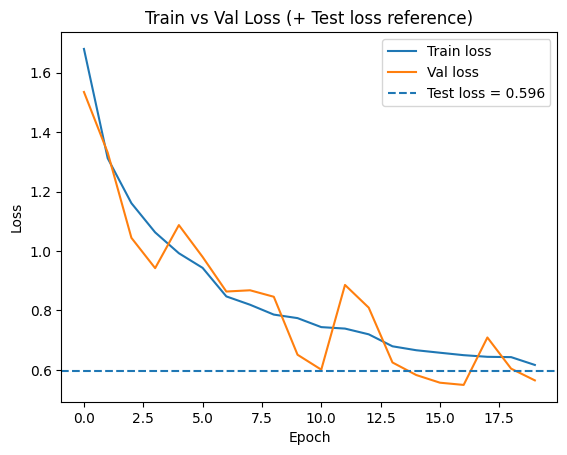

In [9]:
import time   # Track time for deeper statistics.
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks  import EarlyStopping, ReduceLROnPlateau

# Compile the model before training
model4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


# Callbacks to watch the behaviour between val and test to ensure they dont get to far apart
# through adjusting the learning rate and stopping early when val loss stops improving.

early_stop = EarlyStopping(
    monitor="val_accuracy",
    patience=5,                 # stop after 5 epochs with no val_acc improvement
    restore_best_weights=True   # revert weights to best val_acc epoch
)

reduce_lr = ReduceLROnPlateau(  # When the val loss no longer improves. (lower is better), If it detects this, it shrinks the learning rate, letting the model take smaller steps to potentially improve further.
    monitor="val_loss",         # watch validation loss.
    factor=0.5,                 # When its triggered multiply learning rate by 0.5
    patience=2,                 # if validation loss doesnt improve in 2 epochs in a row, trigger the reduction.
    min_lr=1e-5,                # Dont reduce learning rate below 0.00001
    verbose=1                   # print one line at a time per epoch.
)

def format_seconds(s: float) -> str: # a function to improve readabilty of the results in the tests.
    s = max(0.0, float(s))
    m, sec = divmod(s, 60)
    h, m = divmod(m, 60)
    if h >= 1:
        return f"{int(h)}h {int(m)}m {sec:.2f}s"
    if m >= 1:
        return f"{int(m)}m {sec:.2f}s"
    return f"{sec:.2f}s"

t0 = time.perf_counter() # Initialize t0 here

history1 = model4.fit(
    x_tr, y_tr,
    validation_data=(x_val, y_val),  # validation set is taken from training data only
    epochs=20,                       # High number of Epochs to show our over fitting preventing calls backs work.
    batch_size=64,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

t1 = time.perf_counter()       # Measure total training time using a monotonic clock

fit_time = t1 - t0

print(f"Fit time (total): {format_seconds(fit_time)}")


epochs_ran = len(history1.history["loss"])
print("Fit time per epoch (avg):", format_seconds(fit_time / epochs_ran)) # We divide total training time by the number of epochs actually completed.
                                                                          # This matters because EarlyStopping might stop before reaching the max epochs.

print("Train accuracy (last):", history1.history["accuracy"][-1]) # history1.history stores a list of values per epoch.
print("Train loss (last):", history1.history["loss"][-1])         # Using [-1] gives the final epoch value (the last item in the list).

print("Val accuracy (last):", history1.history["val_accuracy"][-1])
print("Val loss (last):", history1.history["val_loss"][-1])



val_acc_best = max(history1.history["val_accuracy"]) # We compute the highest validation accuracy achieved across all epochs.
                                                     # This helps us see the best point during training (often earlier than the final epoch).
best_epoch = 1 + history1.history["val_accuracy"].index(val_acc_best)
print("Val accuracy (best):", val_acc_best, "at epoch", best_epoch)

score = model4.evaluate(x_test, y_test, verbose=0) # The test set (x_test/y_test) was never used during training or validation.
                                                   # This is the true generalization score of the model.
                                                   # model.evaluate returns [loss, accuracy] because we compiled with metrics=['accuracy'].
print("TEST loss:", score[0])
print("TEST accuracy:", score[1])

test_loss, test_acc = model4.evaluate(x_test, y_test, verbose=0)

plt.plot(history1.history["loss"], label="Train loss")
plt.plot(history1.history["val_loss"], label="Val loss")
plt.axhline(test_loss, linestyle="--", label=f"Test loss = {test_loss:.3f}")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Val Loss (+ Test loss reference)")
plt.legend()
plt.show()

Test loss: 0.5964
Test accuracy: 0.7980

Overall metrics:
Precision (macro):  0.808385927264788
Recall (macro):     0.798
F1 (macro):         0.7969474795288356

Precision (weighted):  0.808385927264788
Recall (weighted):     0.798
F1 (weighted):         0.7969474795288355

Per-class report:
              precision    recall  f1-score   support

    airplane     0.8373    0.8080    0.8224      1000
  automobile     0.9000    0.9360    0.9176      1000
        bird     0.7345    0.6750    0.7035      1000
         cat     0.7350    0.5740    0.6446      1000
        deer     0.8745    0.6620    0.7536      1000
         dog     0.6976    0.7590    0.7270      1000
        frog     0.6280    0.9420    0.7536      1000
       horse     0.8413    0.8640    0.8525      1000
        ship     0.9540    0.8510    0.8996      1000
       truck     0.8817    0.9090    0.8951      1000

    accuracy                         0.7980     10000
   macro avg     0.8084    0.7980    0.7969     10000
wei

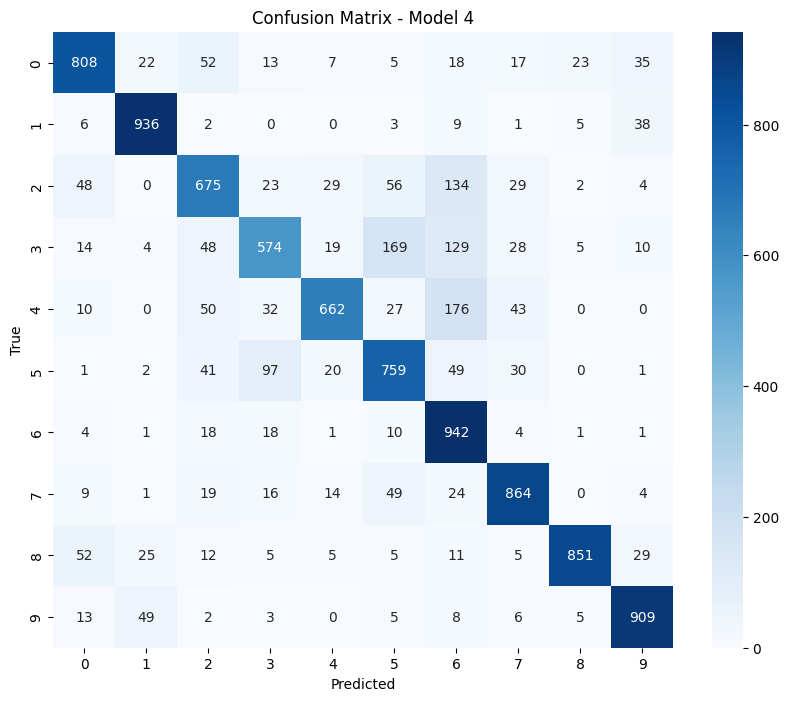

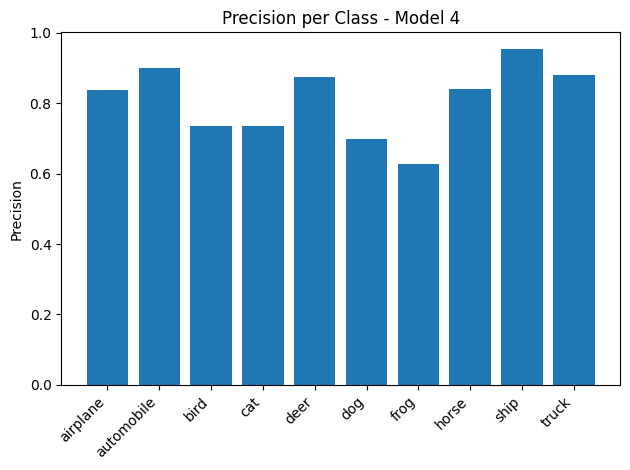

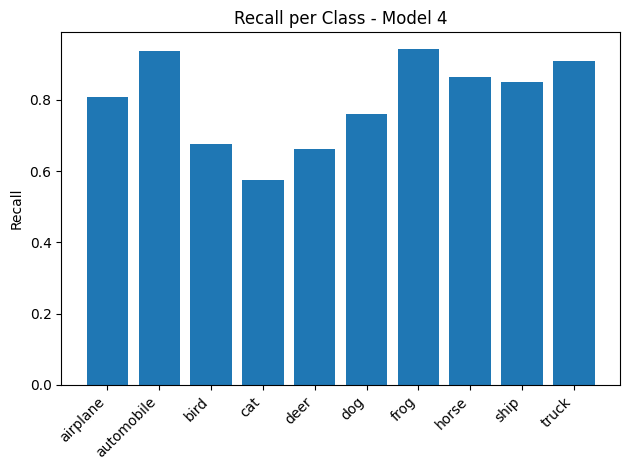

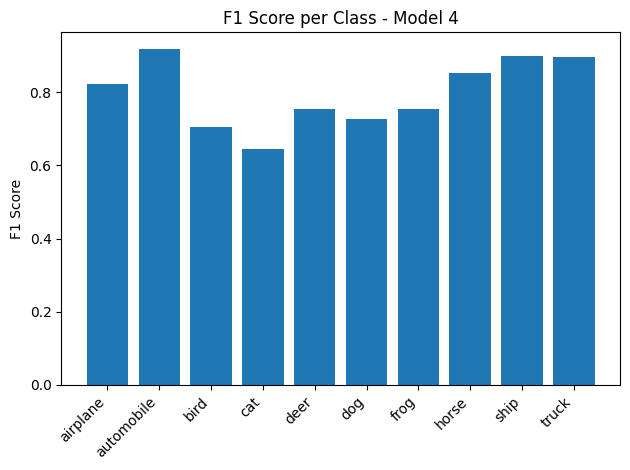

In [10]:
# =========================
# FINAL EVALUATION METRICS
# =========================


import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    precision_score,
    recall_score,
    f1_score
)

class_names = [
    "airplane","automobile","bird","cat","deer",
    "dog","frog","horse","ship","truck"
]

# Evaluate on test set (loss + accuracy) ---
test_loss, test_acc = model4.evaluate(x_test, y_test, verbose=0)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

#  Predict on test set (probabilities -> predicted class) ---
y_test_pred_prob = model4.predict(x_test, verbose=0)       # (N, 10)
y_test_pred = np.argmax(y_test_pred_prob, axis=1)          # (N,)

# True labels as class index
y_true = np.argmax(y_test, axis=1)

# Extra classification metrics (macro + weighted) ---
print("\nOverall metrics:")
print("Precision (macro): ", precision_score(y_true, y_test_pred, average="macro"))
print("Recall (macro):    ", recall_score(y_true, y_test_pred, average="macro"))
print("F1 (macro):        ", f1_score(y_true, y_test_pred, average="macro"))

print("\nPrecision (weighted): ", precision_score(y_true, y_test_pred, average="weighted"))
print("Recall (weighted):    ", recall_score(y_true, y_test_pred, average="weighted"))
print("F1 (weighted):        ", f1_score(y_true, y_test_pred, average="weighted"))

print("\nPer-class report:")
print(classification_report(y_true, y_test_pred, target_names=class_names, digits=4))

#  Build results table with image_id for visual inspection ---
y_conf = np.max(y_test_pred_prob, axis=1)

results4 = pd.DataFrame({
    "image_id": np.arange(len(x_test)),
    "true": y_true,
    "pred": y_test_pred,
    "confidence": y_conf
})

results4["correct"] = (results4["true"] == results4["pred"])
results4["true_name"] = results4["true"].map(lambda i: class_names[int(i)])
results4["pred_name"] = results4["pred"].map(lambda i: class_names[int(i)])

print("\nQuick accuracy check (from results table):", results4["correct"].mean())

# Confusion matrix plot ---
conf_matr = confusion_matrix(y_true, y_test_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matr, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Model 4")
plt.show()

# Per-class precision, recall, f1
prec, rec, f1, sup = precision_recall_fscore_support(
    y_true, y_test_pred, labels=range(10), average=None
)

# --- Precision plot ---
plt.figure()
plt.bar(class_names, prec)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Precision")
plt.title("Precision per Class - Model 4")
plt.tight_layout()
plt.show()

# --- Recall plot ---
plt.figure()
plt.bar(class_names, rec)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Recall")
plt.title("Recall per Class - Model 4")
plt.tight_layout()
plt.show()

# --- F1 plot ---
plt.figure()
plt.bar(class_names, f1)
plt.xticks(rotation=45, ha="right")
plt.ylabel("F1 Score")
plt.title("F1 Score per Class - Model 4")
plt.tight_layout()
plt.show()


In [11]:
print(history1.history.keys())
print("Train accuracy:", history1.history["accuracy"][-1])
print("Train loss:", history1.history["loss"][-1])
print("Validation accuracy:", history1.history["val_accuracy"][-1])
print("Validation loss:", history1.history["val_loss"][-1])

test_loss, test_acc = model4.evaluate(x_test, y_test, verbose=0)



dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])
Train accuracy: 0.7898666858673096
Train loss: 0.616658627986908
Validation accuracy: 0.8026000261306763
Validation loss: 0.5647503733634949


In [26]:
import matplotlib.pyplot as plt

import math

# Assign Identification numbers to each img for recalling individual image results.

def show_images_by_ids(ids, x_data, results_df, n=8, title=None):
    ids = list(ids)[:n]
    cols = 4
    rows = math.ceil(n / cols)

    plt.figure(figsize=(cols * 3.2, rows * 3.2))

    # NEW: overall chart title
    if title:
        plt.suptitle(title, fontsize=14, y=1.02)

    for i, img_id in enumerate(ids):
        row = results_df.loc[results_df["image_id"] == img_id].iloc[0]

        ax = plt.subplot(rows, cols, i + 1)
        plt.imshow(x_data[img_id])
        plt.axis("off")

        # clearer status text
        status = "Correct ✅" if row["correct"] else "Wrong ❌"

        ax.set_title(
            f"{status} | id={img_id}\n"
            f"True: {row['true_name']}\n"
            f"Pred: {row['pred_name']}  (conf: {row['confidence']:.2f})",
            fontsize=9
        )

    plt.tight_layout()
    plt.show()

# --- Match Model 13 total results printout (Model 4) ---
total = len(results4)
false_n = (results4["correct"] == False).sum()
true_n  = (results4["correct"] == True).sum()

print(f"Model 4 — Total: {total}")
print(f"Model 4 — False predictions (wrong): {false_n}")
print(f"Model 4 — Correct predictions: {true_n}")
print(f"Model 4 — Accuracy: {true_n/total:.4f} ({true_n/total*100:.2f}%)")
print(f"Model 4 — Error rate: {false_n/total:.4f} ({false_n/total*100:.2f}%)")

print("\nCorrect breakdown:")
print(results4["correct"].value_counts())


Model 4 — Total: 10000
Model 4 — False predictions (wrong): 2020
Model 4 — Correct predictions: 7980
Model 4 — Accuracy: 0.7980 (79.80%)
Model 4 — Error rate: 0.2020 (20.20%)

Correct breakdown:
correct
True     7980
False    2020
Name: count, dtype: int64


Confident correct sample:
      image_id   true_name   pred_name  confidence
7876      7876  automobile  automobile         1.0
4278      4278  automobile  automobile         1.0
4841      4841  automobile  automobile         1.0
5054      5054       truck       truck         1.0
8522      8522  automobile  automobile         1.0
2450      2450  automobile  automobile         1.0
8931      8931       truck       truck         1.0
871        871  automobile  automobile         1.0


/tmp/ipython-input-1543430522.py:35: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


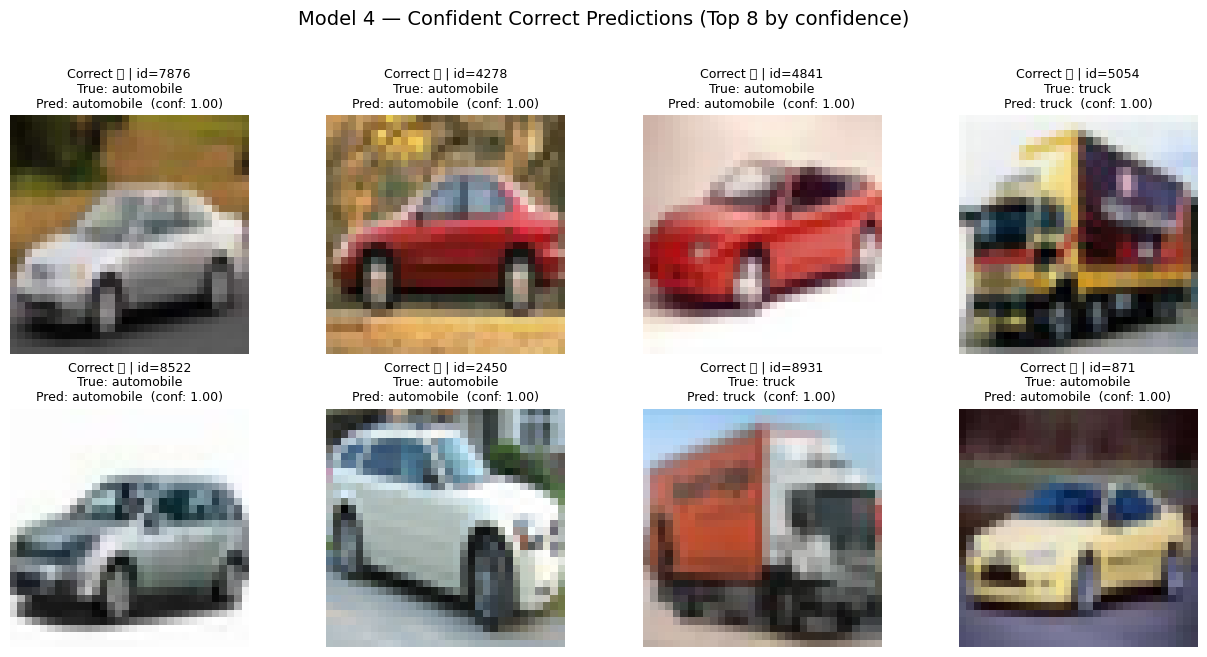

In [27]:
# This shows the imgs that the model thinks are correct. (confident correct)

correct = results4[results4["correct"] == True].sort_values("confidence", ascending=False)
ids_confident_correct = correct.head(8)["image_id"]

print("Confident correct sample:")
print(correct.head(8)[["image_id","true_name","pred_name","confidence"]])

show_images_by_ids(
    ids_confident_correct, x_test, results4, n=8,
    title="Model 4 — Confident Correct Predictions (Top 8 by confidence)"
)


/tmp/ipython-input-1543430522.py:35: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


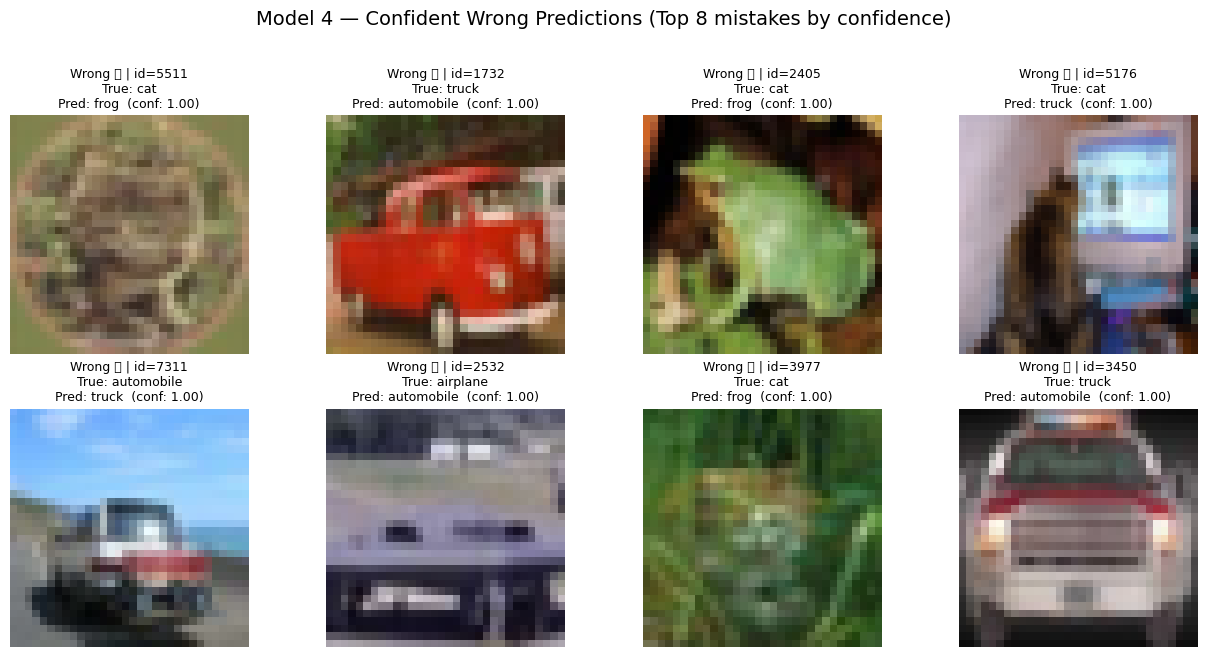

In [28]:
# This shows the imgs that the model thinks are not correct (confident wrong)

wrong = results4[results4["correct"] == False].sort_values("confidence", ascending=False)
ids = wrong.head(8)["image_id"]
show_images_by_ids(
    ids, x_test, results4, n=8,
    title="Model 4 — Confident Wrong Predictions (Top 8 mistakes by confidence)"
)

# T = Test Says
# P = Predicted by the model


/tmp/ipython-input-2372888110.py:29: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


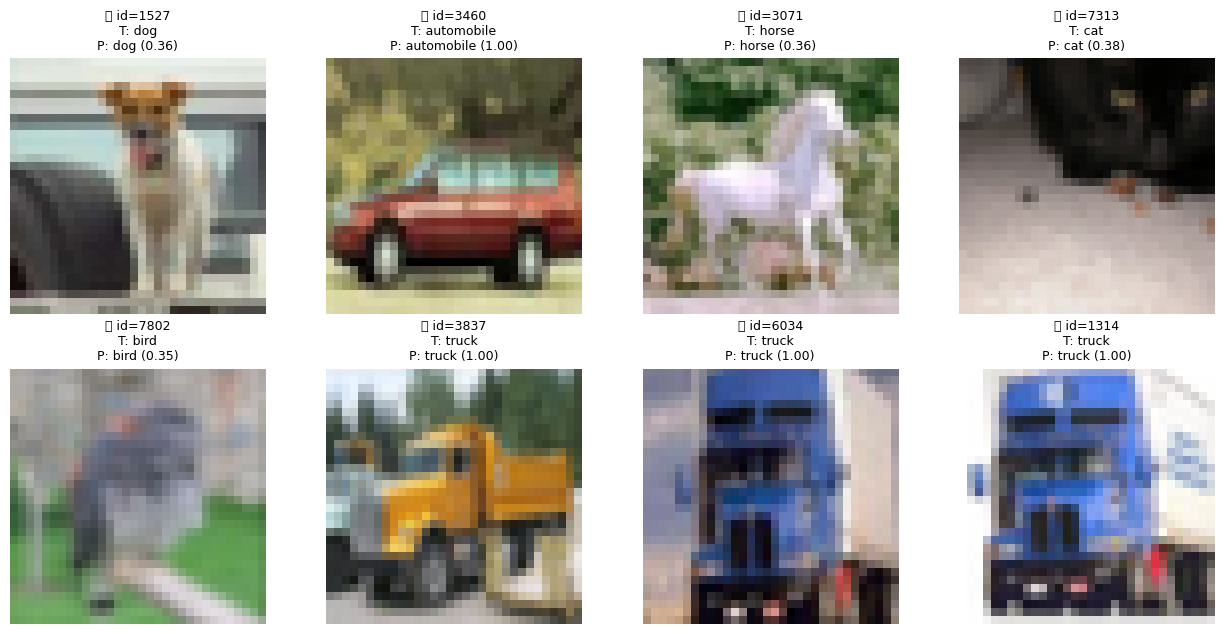

In [15]:
# Random Batch of all confident ranges thaty they are wrong wrong and confident they are correct (cycles on each run request) Done to look for descrepencies in model judgment across other confidence ranges.

correct_sorted = results4[results4["correct"] == True].sort_values("confidence", ascending=False)

top_pool = correct_sorted.head(150)     # choose from top 150
low_pool = correct_sorted.tail(150)     # choose from bottom 150

ids = pd.concat([
    top_pool["image_id"].sample(4),
    low_pool["image_id"].sample(4)
]).sample(8)  # shuffle the final order

show_images_by_ids(ids.tolist(), x_test, results4, n=8)


In [ ]:
# Load model syntax

# import tensorflow as tf
# model1 = tf.keras.models.load_model("model1.keras")
# print("Loaded model1.keras")


In [16]:
import os
print("Working directory:", os.getcwd())
print("Files here:", os.listdir())

# Save full model (best default)
model4.save("cifar10.v4_G1_cnn.keras")


Working directory: /content
Files here: ['.config', 'sample_data']


This concludes Model-4

Comparing Models

In [18]:
import os
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# --- sanity checks ---
print("x_val:", x_val.shape, "y_val:", y_val.shape)
print("x_test:", x_test.shape, "y_test:", y_test.shape)

model_files = {
    "Model 4 (current)": None,  # in-memory model4
    "Model 1": "/content/cifar10.v1_G1_cnn.keras",
    "Model 4 (actual)": "/content/cifar10.v4_G1_cnn.keras",
    "Model 6": "/content/cifar10.v6_G1_cnn.keras",
    "Model 14": "/content/cifar10.model14.keras",
    "Model 13": "/content/cifar10.v13_G1_cnn.keras",
    "Model 12": "/content/cifar10.v12_G1_cnn.keras",
}

def safe_compile(m):
    m.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return m

def evaluate_on_sets(m, x_val, y_val, x_test, y_test):
    val_loss, val_acc = m.evaluate(x_val, y_val, verbose=0)
    test_loss, test_acc = m.evaluate(x_test, y_test, verbose=0)
    return val_loss, val_acc, test_loss, test_acc

def classification_metrics_from_test(m, x_test, y_test):
    """
    Computes precision/recall/f1 on the test set.
    Assumes y_test is one-hot (N,10). If yours isn't, this still works if y_test is integer labels.
    """
    y_prob = m.predict(x_test, verbose=0)
    y_pred = np.argmax(y_prob, axis=1)

    if len(y_test.shape) > 1 and y_test.shape[1] > 1:
        y_true = np.argmax(y_test, axis=1)
    else:
        y_true = y_test

    return {
        "precision_macro": precision_score(y_true, y_pred, average="macro", zero_division=0),
        "recall_macro": recall_score(y_true, y_pred, average="macro", zero_division=0),
        "f1_macro": f1_score(y_true, y_pred, average="macro", zero_division=0),
        "precision_weighted": precision_score(y_true, y_pred, average="weighted", zero_division=0),
        "recall_weighted": recall_score(y_true, y_pred, average="weighted", zero_division=0),
        "f1_weighted": f1_score(y_true, y_pred, average="weighted", zero_division=0),
    }

rows = []

# 1) Evaluate your current in-memory model 4
m4 = safe_compile(model4)
val_loss, val_acc, test_loss, test_acc = evaluate_on_sets(m4, x_val, y_val, x_test, y_test)
cls = classification_metrics_from_test(m4, x_test, y_test)

rows.append({
    "model": "Model 4 (current)",
    "val_accuracy": val_acc,
    "test_accuracy": test_acc,
    "val_loss": val_loss,
    "test_loss": test_loss,
    **cls
})

# 2) Load and evaluate the other models (skip missing files safely)
for name, path in model_files.items():
    if path is None:
        continue

    if not os.path.exists(path):
        print(f"SKIP (missing file): {name} -> {path}")
        continue

    loaded = tf.keras.models.load_model(path)
    loaded = safe_compile(loaded)

    val_loss, val_acc, test_loss, test_acc = evaluate_on_sets(loaded, x_val, y_val, x_test, y_test)
    cls = classification_metrics_from_test(loaded, x_test, y_test)

    rows.append({
        "model": name,
        "val_accuracy": val_acc,
        "test_accuracy": test_acc,
        "val_loss": val_loss,
        "test_loss": test_loss,
        **cls
    })

df_compare = pd.DataFrame(rows).sort_values("test_accuracy", ascending=False)

print("\n=== Model comparison (sorted by test accuracy) ===")
display(df_compare)


x_val: (5000, 32, 32, 3) y_val: (5000, 10)
x_test: (10000, 32, 32, 3) y_test: (10000, 10)


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 26 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



=== Model comparison (sorted by test accuracy) ===


,model,val_accuracy,test_accuracy,val_loss,test_loss,precision_macro,recall_macro,f1_macro,precision_weighted,recall_weighted,f1_weighted
5,Model 13,0.9916,0.8645,0.029554,0.538680,0.865179,0.8645,0.863311,0.865179,0.8645,0.863311
2,Model 4 (actual),0.8568,0.8504,0.420136,0.461486,0.855960,0.8504,0.849112,0.855960,0.8504,0.849112
4,Model 14,0.8840,0.8474,0.325509,0.455658,0.852245,0.8474,0.846882,0.852245,0.8474,0.846882
3,Model 6,0.9968,0.8014,0.025375,0.800895,0.799625,0.8014,0.798979,0.799625,0.8014,0.798979
0,Model 4 (current),0.8084,0.7980,0.549451,0.596436,0.808386,0.7980,0.796947,0.808386,0.7980,0.796947
1,Model 1,0.8604,0.6354,0.447072,1.254702,0.633293,0.6354,0.633179,0.633293,0.6354,0.633179
6,Model 12,0.0868,0.0985,2.306910,2.307527,0.107987,0.0985,0.046074,0.107987,0.0985,0.046074


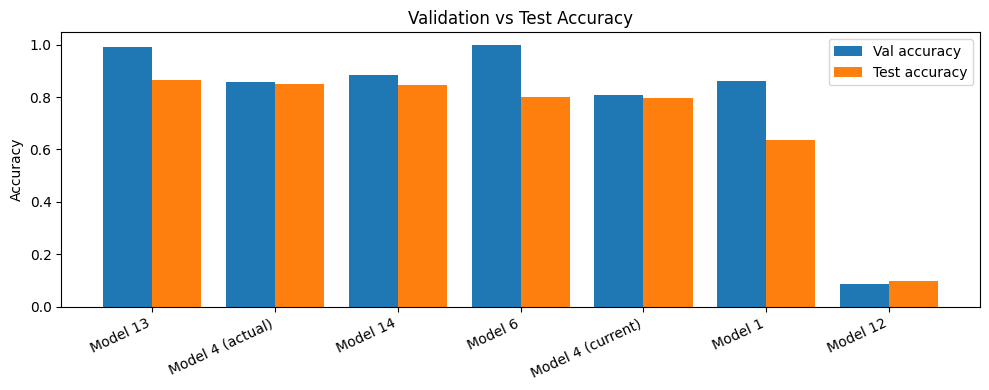

In [19]:
plt.figure(figsize=(10,4))
x = range(len(df_compare))
plt.bar([i - 0.2 for i in x], df_compare["val_accuracy"], width=0.4, label="Val accuracy")
plt.bar([i + 0.2 for i in x], df_compare["test_accuracy"], width=0.4, label="Test accuracy")
plt.xticks(list(x), df_compare["model"], rotation=25, ha="right")
plt.ylabel("Accuracy")
plt.title("Validation vs Test Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

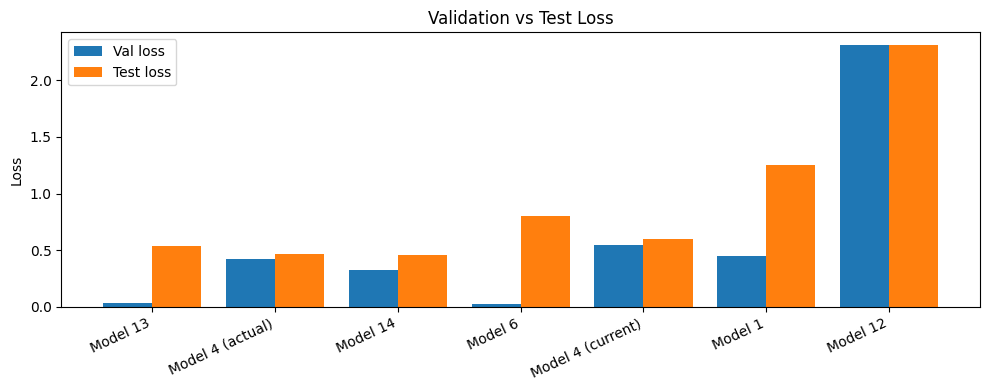

In [20]:
plt.figure(figsize=(10,4))
x = range(len(df_compare))
plt.bar([i - 0.2 for i in x], df_compare["val_loss"], width=0.4, label="Val loss")
plt.bar([i + 0.2 for i in x], df_compare["test_loss"], width=0.4, label="Test loss")
plt.xticks(list(x), df_compare["model"], rotation=25, ha="right")
plt.ylabel("Loss")
plt.title("Validation vs Test Loss")
plt.legend()
plt.tight_layout()
plt.show()


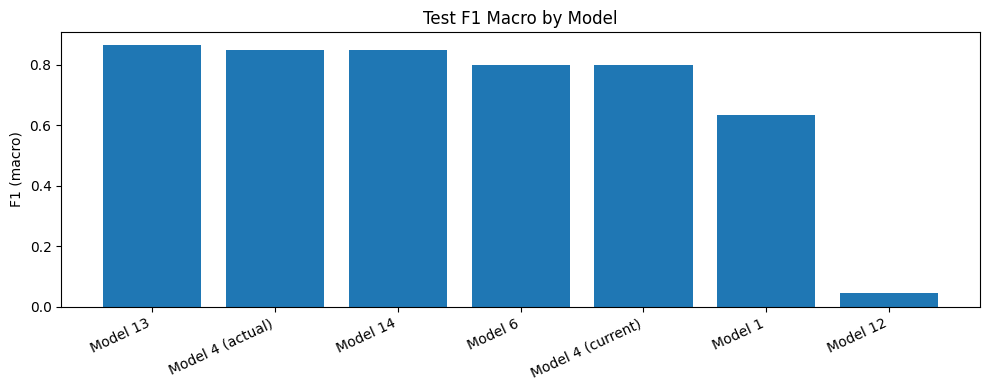

In [21]:
plt.figure(figsize=(10,4))
plot_df = df_compare.sort_values("f1_macro", ascending=False)
plt.bar(plot_df["model"], plot_df["f1_macro"])
plt.xticks(rotation=25, ha="right")
plt.ylabel("F1 (macro)")
plt.title("Test F1 Macro by Model")
plt.tight_layout()
plt.show()
